<a href="https://colab.research.google.com/github/Changyoon-Lee/realization_seq2seq/blob/master/seq2seq(mecab_%EC%97%AD%EB%B0%A9%ED%96%A5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from konlpy.tag import Mecab
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

In [ ]:
import pandas as pd
news_df = pd.read_excel('/gdrive/My Drive/강의자료/kor.xlsx', sheet_name='Sheet1')

train_df, val_df, test_df = news_df.iloc[:50000, 1:], news_df.iloc[50000:63000, 1:], news_df.iloc[63000:, 1:]

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
def preprocess_sentences_eng(sentences):
    sentence = []
    for line in sentences:
        tokens = word_tokenize(line)
        tokens.insert(0,'<start>')
        tokens.append('<end>')
        sentence.append(' '.join(tokens))
    return sentence
def preprocess_sentences_kor(sentences):
    mecab = Mecab()
    sentence = []
    for line in sentences:
        tokens = mecab.morphs(line)
        tokens.insert(0,'<end>')
        tokens.append('<start>')
        sentence.append(' '.join(tokens[::-1]))
    return sentence

def backprocess_sentence(sentence):
    tokens = sentence.split()
    tokens = tokens[1:-1]
    return ' '.join(tokens)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='', oov_token='oov')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
train_en, test_en, val_en, train_kor, test_kor, val_kor = train_df['en'], test_df['en'], val_df['en'], train_df['ko'], test_df['ko'], val_df['ko']

In [ ]:
train_en = preprocess_sentences_eng(train_en)
train_kor = preprocess_sentences_kor(train_kor)
val_en = preprocess_sentences_eng(val_en)
val_kor = preprocess_sentences_kor(val_kor)

In [ ]:
#train_set 들로 tokenizer에 fit 시킨다
input_tensor_train, inp_lang = tokenize(train_kor)
target_tensor_train, targ_lang = tokenize(train_en)

In [ ]:
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
print('kor vocab size : {}\nen vocab size : {}'.format(len(inp_lang.word_index), len(targ_lang.word_index)))
print('kor_sentence_maxlen : {}\nen_sentence_maxlen : {}'.format(max_length_inp, max_length_targ))

kor vocab size : 17827
en vocab size : 15640
kor_sentence_maxlen : 32
en_sentence_maxlen : 21


In [ ]:
def tokenize_test(sent,lang='en'):
    if lang=='ko':
        tensor = inp_lang.texts_to_sequences(sent)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen = max_length_inp,
                                                         padding='post')
        return tensor
    else :
        tensor = targ_lang.texts_to_sequences(sent)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen =max_length_targ,
                                                         padding='post')
        return tensor

In [ ]:
input_tensor_val = tokenize_test(val_kor, lang='ko')
target_tensor_val = tokenize_test(val_en, lang='en')

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
convert(targ_lang, target_tensor_train[0])

2 ----> <start>
5 ----> i
47 ----> go
7 ----> to
6 ----> the
6439 ----> attic
225 ----> every
584 ----> evening
7 ----> to
148 ----> meet
8459 ----> bat
4 ----> .
3 ----> <end>


In [ ]:
from tensorflow import keras
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

#validation set 나누기

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
 

(TensorShape([64, 32]), TensorShape([64, 21]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.random.uniform(shape=(self.batch_sz, self.enc_units), minval=-0.08, maxval=0.08)

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 32, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 32, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15641)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = '/gdrive/My Drive/강의자료/seq2seq_mecab'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

def test_step(inp, targ, enc_hidden):
  loss = 0
 
  enc_out, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [ ]:
EPOCHS = 10
loss_data = {'loss':[],'val_loss':[]}
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  enc_hidden = encoder.initialize_hidden_state()
  for inp, targ in val_dataset.take(steps_per_epoch_val):
    batch_val_loss = test_step(inp, targ, enc_hidden)
    val_loss += batch_val_loss
  

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  loss_data['loss'].append(total_loss / steps_per_epoch)
  loss_data['val_loss'].append(val_loss/steps_per_epoch_val)
  print('Epoch {} Loss {:.4f} val_los {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch, val_loss/steps_per_epoch_val))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
import pickle
with open('/gdrive/My Drive/강의자료/seq2seq_mecab/loss_data.pickle','wb') as f:
    pickle.dump(loss_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('loss_data 저장 완료')

loss_data 저장 완료


In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentences_kor(sentence)[0]
  inputs = inp_lang.texts_to_sequences([sentence])[0]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    result += targ_lang.index_word[predicted_id] + ' '



    # the predicted ID is fed back into the mode

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
translate(['안녕'])

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<function matplotlib.pyplot.show>

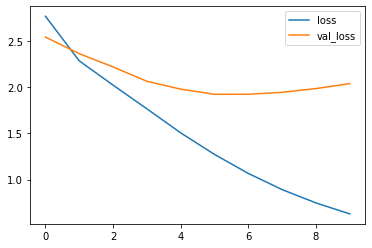

In [ ]:
import pandas as pd 
df = pd.DataFrame(loss_data)
import matplotlib.pyplot as plt

plt.plot(df['loss'], label= 'loss')
plt.plot(df['val_loss'], label= 'val_loss')
plt.legend()
plt.show

## BLUE SCORE

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
score_list = []
smoothie = SmoothingFunction().method4
for i in range(len(test_kor.values)):
    
    reference = [word_tokenize(test_en.values[i].lower())]
    result,_,_= evaluate([test_kor.values[i]])
    candidate = result.split()
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    score_list.append(score)
    if i<20:
        print('-'*20)
        print('input : {}'.format(test_kor.values[i]))
        print('실제값 : {}\n예측값 : {}'.format(' '.join(reference[0]), ' '.join(candidate)))

score = sum(score_list)/len(score_list)
print('score는 {}'.format(score))

--------------------
input : 저는 오늘 그 이유에 대해 말하고자해요.
실제값 : and i 'm here to explain the reason for this .
예측값 : today , i want to talk about that professor today .
--------------------
input : 오늘 저는 성형수술의 위험성에 대해 말하고자해요.
실제값 : i want to say about the cosmetic sergery today .
예측값 : today , i want to talk about the importance of the truth of the future .
--------------------
input : 상기와 같은 조건으로 재계약을 하고자해요.
실제값 : we would like to renew the contract in the condition above .
예측값 : i want to sign the contract with the above above .
--------------------
input : 우리의 방학이 다음주에 시작 돼.
실제값 : our summer vacation starts next week .
예측값 : our vacation begins for next week .
--------------------
input : 그녀는 새로운 것을 창조해 내는 재밌는 작가야.
실제값 : she is an interesting writer who creates new things .
예측값 : she is a fun that i can enjoy the new zealand .
--------------------
input : 비오는 계절이 끝나자마자 시작돼요.
실제값 : it begins soon after the rainy season is over .
예측값 : taeyeon is completed as the weather season .
----------

---
### Moses' script for detokenized BLEU
참고 : https://pypi.org/project/bleu/

In [ ]:
!pip install --upgrade bleu

In [ ]:
pip install --upgrade git+git://github.com/zhijing-jin/bleu.git

In [ ]:
from bleu import list_bleu
ref = ['wow , this dog is huge .']
ref1 = ['This cat is white .',
             'wow , this is a huge dog .']
hyp = ['wowww , the dog is huge !']
hyp1 = ["it 's a white kitten .",
             'wow , this dog is huge !']
list_bleu([ref], hyp)

0.0

In [ ]:
test_kor.values[:10]

array(['그것을 우리가 미리 확인하고 준비할 수 있을까요?',
       '이 프로그램은 준비하기 위한 과정으로 좋은 출발점이 될 것이에요.',
       '오늘 내가 인터넷으로 주문한 컴퓨터가 도착했어요.', '우리집에서 클래식 음악을 들었어.',
       '사실대로 말하면, 저도 거기에서 왔어요.', '남녀 공학인 학교가 일반화되고 있어요.',
       '이름에 학번을 넣는 것을 잊어 버렸어요.', '운동신경이 좋아 모든 운동을잘해요.',
       '우리 애 들은 교회 수련회 갔어.', '국내를 선호하는 사람은 손을 들어주세요.'], dtype=object)

In [ ]:
predicted_sentence = []
for i in test_kor.values[:300]:
    a,_,_= evaluate([i])
    predicted_sentence.append(a.capitalize())

In [ ]:
from bleu import list_bleu
print(test_en.values[0], predicted_sentence[0])
score = list_bleu([test_en.values[:300]], predicted_sentence[:300])
print(score)


Could we check in advance and prepare that? Could we check our check and check out this coupon? 
7.88


In [ ]:
def trans(lang, sentences):
    result_list=[]
    for line in sentences:
        result = ''
        for idx in line:
            if idx==1:continue
            result += lang.index_word[idx] + ' '
            if lang.index_word[idx] == '<end>':
                result_list.append(result)
                break

        
    return result_list